In [1]:
import torch
from numba import cuda
import numpy as np
from tqdm import tqdm
import pickle
import gc
import h5py

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import sys, os
sys.path.append('/home/sebastian/Desktop/github_intern/intern')

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM_ import RTRBM
from boltzmann_machines.cp_rbm import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *
from data.poisson_data_v import PoissonTimeShiftedData
from utils.moments_plot import infer_and_get_moments_plot
from PGM.utilities import RBM_utils

path2repository = '/home/sebastian/Desktop/github_intern/intern/PGM/data/Zebrafish/' # Full path to the directory containing data, pretrained models and atlas information. See the gin.g-node repo.

/home/sebastian/Desktop/github_intern/intern/PGM/source/numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/sebastian/Desktop/github_intern/intern/PGM/source/numba_utilities.py:1125: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
/home/sebastian/Desktop/github_intern/intern/PGM/source/numba_utilities.py:1126: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
/home/sebastian/Desktop/github_intern/intern/PGM/source/numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [2]:
def train_test_split(data, train_batches=7, test_batches=3, random=True):
    n_batches = train_batches + test_batches
    batch_size = data.shape[1] // n_batches
    train = torch.zeros(data.shape[0], batch_size, train_batches)
    test = torch.zeros(data.shape[0], batch_size, test_batches)
    
    if random:
        batch_index_shuffled = torch.randperm(n_batches)
    else:
        batch_index_shuffled = [0, 2, 3, 4, 7, 8, 9, 1, 5, 6]
    i = 0
    for batch in range(train_batches):
        j = batch_index_shuffled[i]
        train[:, :, batch] = data[:, j * batch_size:(j + 1) * batch_size]
        i += 1

    for batch in range(test_batches):
        j = batch_index_shuffled[i]
        test[:, :, batch] = data[:, j * batch_size:(j + 1) * batch_size]
        i += 1

    return train, test

def load_dataset(path2dataset):
    f = h5py.File(path2dataset, 'r')
    try:
        Coordinates = f['Data']['Brain']['Coordinates'][()].T # Spatial coordinates
    except:
        print('Coordinates not found')
        Coordinates = None
    try:
        ZBrainCoordinates = f['Data']['Brain']['ZBrainCoordinates'][()].T # Spatial coordinates in Zbrain reference frame.
    except:
        print('Zbrain coordinates not found')
        ZBrainCoordinates = None
    try:
        Time = f['Data']['Brain']['Times'][()][:,0] # Recording time.
    except:
        print('Time not found')
        Time = None
    try:
        Labels = f['Data']['Brain']['Labels'][()].T.astype(np.bool)
    except:
        print('Region labels not found')
        Labels = None
    try:
        Spikes = f['Data']['Brain']['Analysis']['ThresholdedSpikes'][()].astype(np.bool)
    except:
        print('Spikes not found')
        Spikes = None
    try:
        if 'DFF_align' in f['Data']['Brain']['Analysis'].keys():
            Fluorescence = f['Data']['Brain']['Analysis']['DFF_align'][()]
        else:
            Fluorescence = f['Data']['Brain']['Analysis']['DFF'][()]
    except:
        print('Fluorescence signal DFF not found')
        Fluorescence = None
    f.close()
    
    mask = Labels.max(-1) # Discard neurons not mapped to Zbrain atlas.
    Spikes = Spikes[:,mask]
    Fluorescence = Fluorescence[:,mask]
    Coordinates = Coordinates[mask]
    ZBrainCoordinates = ZBrainCoordinates[mask]
    Labels = Labels[mask]
    return Spikes,Fluorescence,Time,Coordinates,ZBrainCoordinates,Labels
    

dataset_index = 6# The dataset used.

    
list_datasets = [
    'fish1_20180706_Run04',
    'fish2_20180911_Run01',
    'fish3_20180912_Run01',
    'fish4_20180913_Run01',
    'fish5_20190109_Run04',
    'fish6_20181206_Run03',
    'fish7_20190102_Run01',
    'fish8_20181206_Run05',    
]

dataset = list_datasets[dataset_index]    

Spikes,Fluorescence,Time,Coordinates,ZBrainCoordinates,Labels = \
load_dataset('/home/sebastian/Desktop/github_intern/intern/PGM/data/Zebrafish/neural_recodings/full_calcium_data_sets/rbm_'+dataset+'.h5')#path2dataset

T = len(Time)
nNeurons = Spikes.shape[-1]
print('Recording has %s time frames and %s neurons' %(T,nNeurons))

train, test = reshape(train_test_split(torch.tensor(Spikes).T, random=False)[0]), reshape(train_test_split(torch.tensor(Spikes).T, random=False)[1])
rbm = RBM_utils.loadRBM(path2repository + 'cRBM_models/rbm_'+dataset+'_retrained.data')

<ipython-input-2-013b93c92318>:42: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Labels = f['Data']['Brain']['Labels'][()].T.astype(np.bool)
<ipython-input-2-013b93c92318>:47: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Spikes = f['Data']['Brain']['Analysis']['ThresholdedSpikes'][()].astype(np.bool)


Recording has 7500 time frames and 25259 neurons


In [3]:
dataset

'fish7_20190102_Run01'

In [4]:
print(train.shape, test.shape)

torch.Size([25259, 5250]) torch.Size([25259, 2250])


In [5]:
for i in range(1, 525+1):
    if (525 % i) == 0:
        print(i)


1
3
5
7
15
21
25
35
75
105
175
525


In [6]:
print(5250/30, 2250/30)

175.0 75.0


In [7]:
print(train.shape, test.shape)

torch.Size([25259, 5250]) torch.Size([25259, 2250])


In [8]:
rbm.weights.shape

(100, 25259)

In [9]:

"""
#fish 1
train_7, test_7 = reshape(train, T=7, n_batches=550), reshape(test, T=7, n_batches=235)
train_16, test_16 = reshape(train, T=16, n_batches=240), reshape(test, T=16, n_batches=103)
train_30, test_30 = reshape(train, T=30, n_batches=128), reshape(test, T=30, n_batches=55)

fish 4:
train_14, test_14 = reshape(train, T=14, n_batches=250), reshape(test, T=14, n_batches=107)
train_25, test_25 = reshape(train, T=25, n_batches=140), reshape(test, T=25, n_batches=60)
train_35, test_35 = reshape(train, T=35, n_batches=100), reshape(test, T=35, n_batches=42)
train_list, test_list = [train_14, train_25, train_35], [test_14, test_25, test_35]

#fish 5:
train_15, test_15 = reshape(train, T=15, n_batches=350), reshape(test, T=15, n_batches=150)
train_21, test_21 = reshape(train, T=21, n_batches=250), reshape(test, T=21, n_batches=107)
train_25, test_25 = reshape(train, T=25, n_batches=210), reshape(test, T=25, n_batches=90)
train_list, test_list = [train_15, train_21, train_25], [test_15, test_21, test_25]


#fish 6
train_10, test_10 = reshape(train, T=10, n_batches=256), reshape(test, T=10, n_batches=109)
train_16, test_16 = reshape(train, T=16, n_batches=160), reshape(test, T=16, n_batches=68)
train_20, test_20 = reshape(train, T=20, n_batches=128), reshape(test, T=20, n_batches=54)

#fish 2
train_10, test_10 = reshape(train, T=10, n_batches=420), reshape(test, T=10, n_batches=180)
train_15, test_15 = reshape(train, T=15, n_batches=280), reshape(test, T=15, n_batches=120)
train_20, test_20 = reshape(train, T=20, n_batches=210), reshape(test, T=20, n_batches=90)


#fish 3
train_15, test_15 = reshape(train, T=15, n_batches=259), reshape(test, T=15, n_batches=111)
train_21, test_21 = reshape(train, T=21, n_batches=185), reshape(test, T=21, n_batches=79)
train_35, test_35 = reshape(train, T=35, n_batches=111), reshape(test, T=35, n_batches=47)

#fish 8
train_8, test_8 = reshape(train, T=8, n_batches=320), reshape(test, T=8, n_batches=137)
train_16, test_16 = reshape(train, T=16, n_batches=160), reshape(test, T=16, n_batches=68)
train_32, test_32 = reshape(train, T=32, n_batches=80), reshape(test, T=32, n_batches=34)

"""


#fish 7
train_15, test_15 = reshape(train, T=15, n_batches=350), reshape(test, T=15, n_batches=150)
train_21, test_21 = reshape(train, T=21, n_batches=250), reshape(test, T=21, n_batches=107)
train_30, test_30 = reshape(train, T=30, n_batches=175), reshape(test, T=30, n_batches=75)

train_list, test_list = [train_15, train_21, train_30], [test_15, test_21, test_30]

In [10]:
train_15.shape

torch.Size([25259, 15, 350])

100%|██████████| 150/150 [00:00<00:00, 1228800.00it/s]


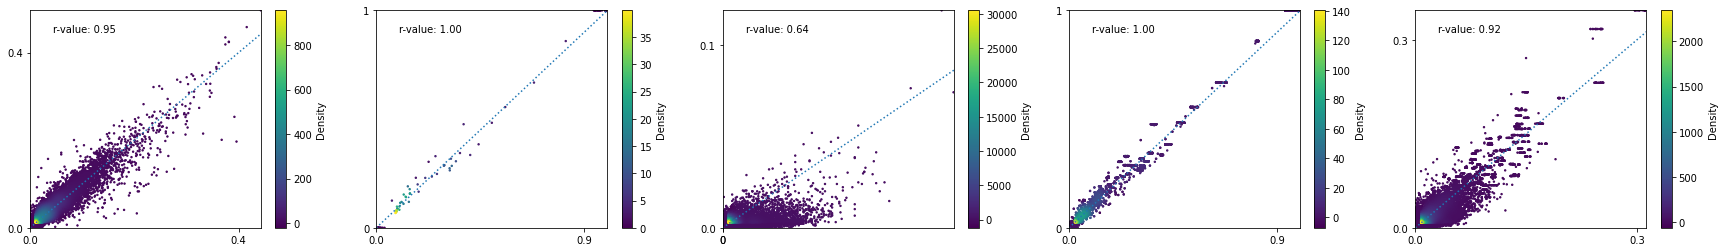

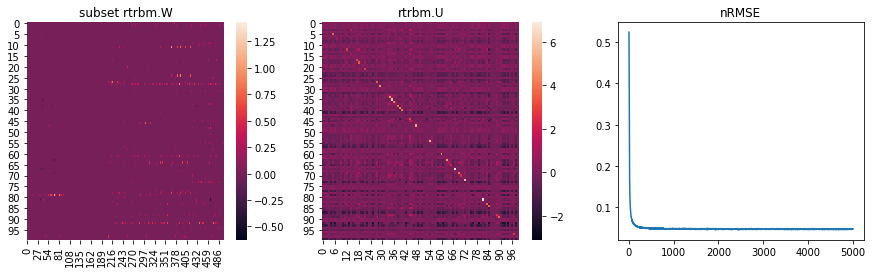

100%|██████████| 107/107 [00:00<00:00, 1253604.83it/s]


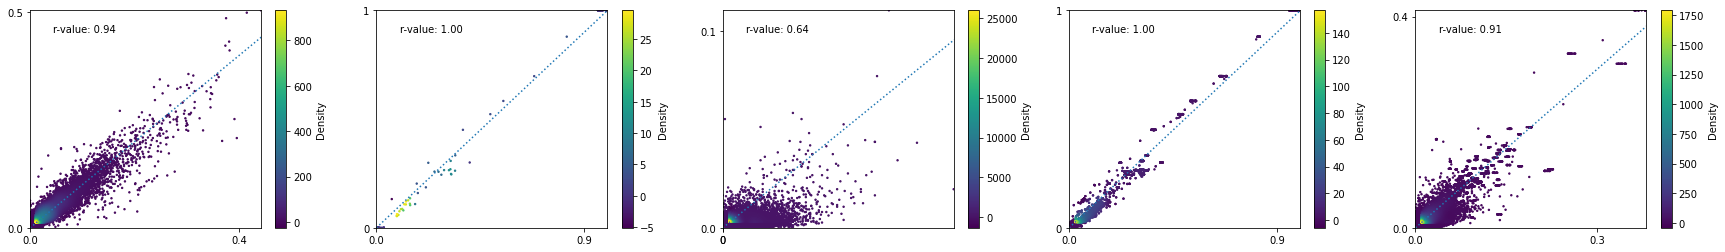

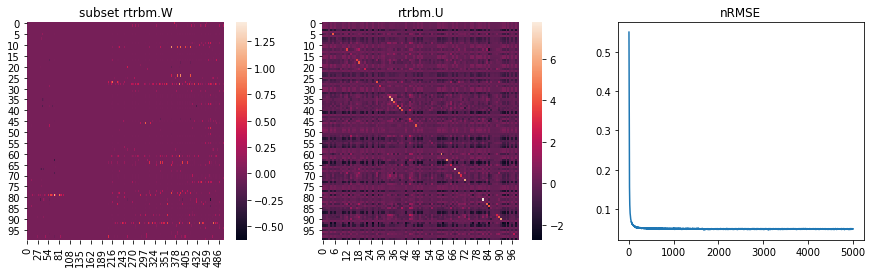

100%|██████████| 75/75 [00:00<00:00, 1200659.54it/s]


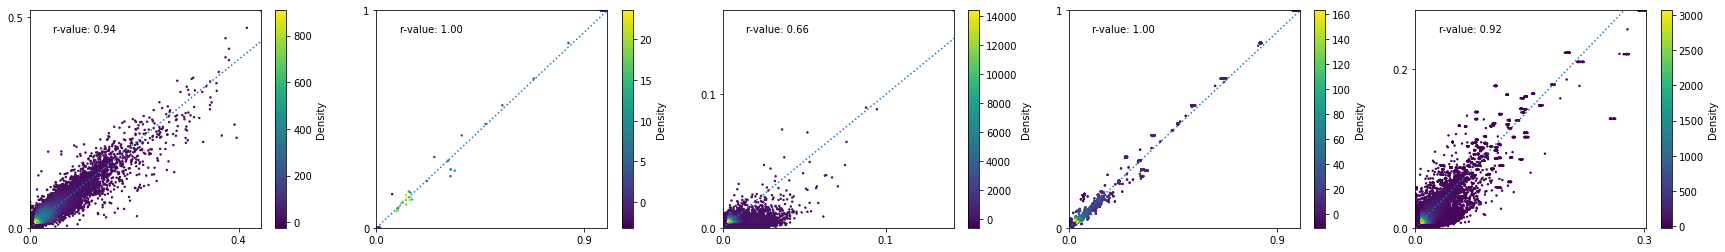

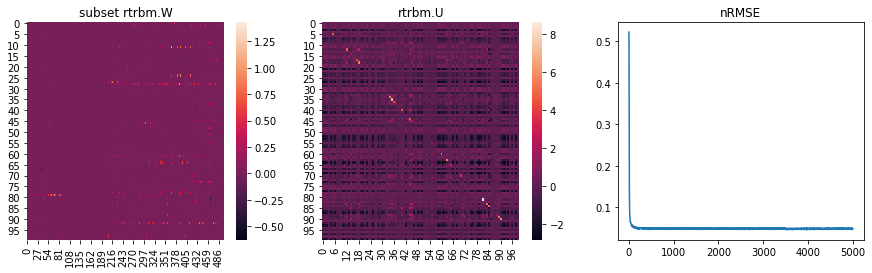

In [11]:
path2dir = path2repository + 'Transfer learning RTRBM trial/'
T = [15, 21, 30]
batch_size = [100, 75, 50]

sp=1e-7
for i, (train, test) in enumerate(zip(train_list, test_list)):
    if os.path.isfile(path2dir + 'tranfer_whole_brain_rtrbm_T_'+str(T[i])+dataset):
        rtrbm = torch.load(path2dir + 'tranfer_whole_brain_rtrbm_T_'+str(T[i])+dataset)
        fig, ax = plt.subplots(1, 3, figsize=(15, 4))

        sns.heatmap(rtrbm.W[:, :500].cpu(), ax=ax[0])
        ax[0].set_title('subset rtrbm.W')

        sns.heatmap(rtrbm.U.cpu(), ax=ax[1])
        ax[1].set_title('rtrbm.U')

        ax[2].plot(rtrbm.errors)
        ax[2].set_title('nRMSE')
        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(15, 4))

        sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=ax[0])
        ax[0].set_ylim([1e-3, 1e2])
        ax[0].set_xlim([-3, 3])
        ax[0].set_title('cRBM weights')

        sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10],ax=ax[1])
        ax[1].set_ylim([1e-3, 1e2])
        ax[1].set_xlim([-3, 3])
        ax[1].set_title('Transfer learning RTRBM weights')


        sns.kdeplot(rtrbm.U.cpu().ravel(), log_scale=[0, 10],ax=ax[2])
        ax[2].set_ylim([1e-3, 1e2])
        ax[2].set_xlim([-3, 3])
        ax[2].set_title('Transfer learning RTRBM temporal weights')
        plt.show()

        ,_, _ =  infer_and_get_moments_plot(path2dir + 'tranfer_whole_brain_rtrbm_T_'+str(T[i])+dataset\
             , test=test, pre_gibbs_k=100, gibbs_k=100, mode=1, n_batches=None, n=1000, m=50000, plot=True, machine='rtrbm_parallel')
        plt.show()

        continue

    rtrbm = RTRBM(train, n_hidden=rbm.weights.shape[0], device='cuda')
    rtrbm.W = torch.tensor(rbm.weights, dtype=torch.float, device='cuda')
    rtrbm.params = [rtrbm.W, rtrbm.U, rtrbm.b_h, rtrbm.b_v, rtrbm.b_init]
    rtrbm.learn(n_epochs=5000, max_lr=1e-3, min_lr=5e-6, lr_schedule='geometric_decay', 
                batch_size=batch_size[i], CDk=10, mom=0.9, wc=0.0002, sp=sp, x=2, n=1000)


    torch.save(rtrbm, path2dir + 'tranfer_whole_brain_rtrbm_T_'+str(T[i])+dataset)
    _,_, _ =  infer_and_get_moments_plot(path2dir + 'tranfer_whole_brain_rtrbm_T_'+str(T[i])+dataset\
             , test=test, pre_gibbs_k=100, gibbs_k=100, mode=1, n_batches=None, n=1000, m=50000, plot=True, machine='rtrbm_parallel')
    plt.show()


    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    sns.heatmap(rtrbm.W[:, :500].cpu(), ax=ax[0])
    ax[0].set_title('subset rtrbm.W')

    sns.heatmap(rtrbm.U.cpu(), ax=ax[1])
    ax[1].set_title('rtrbm.U')

    ax[2].plot(rtrbm.errors)
    ax[2].set_title('nRMSE')
    plt.show()

    """    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=ax[0])
    ax[0].set_ylim([1e-3, 1e2])
    ax[0].set_xlim([-3, 3])
    ax[0].set_title('cRBM weights')

    sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10],ax=ax[1])
    ax[1].set_ylim([1e-3, 1e2])
    ax[1].set_xlim([-3, 3])
    ax[1].set_title('Transfer learning RTRBM weights')


    sns.kdeplot(rtrbm.U.cpu().ravel(), log_scale=[0, 10],ax=ax[2])
    ax[2].set_ylim([1e-3, 1e2])
    ax[2].set_xlim([-3, 3])
    ax[2].set_title('Transfer learning RTRBM temporal weights')

    plt.show()
    """

    

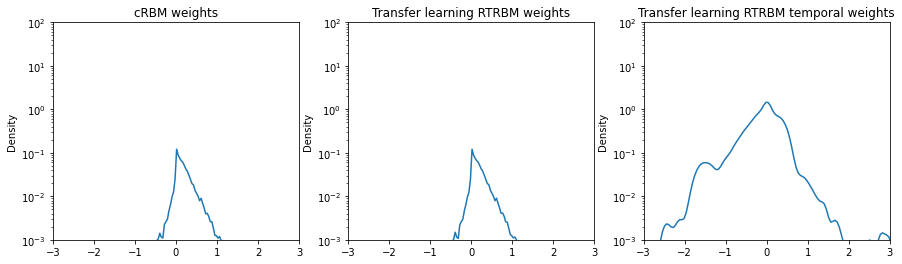

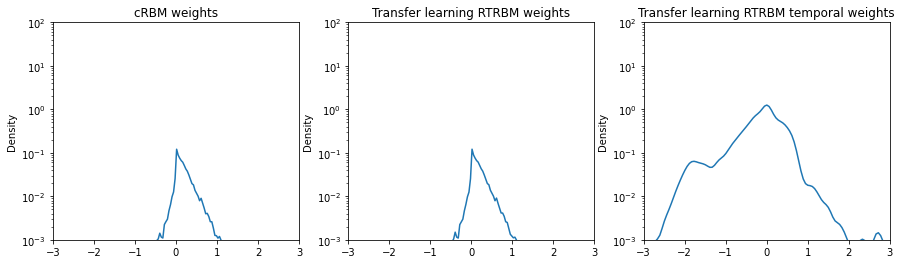

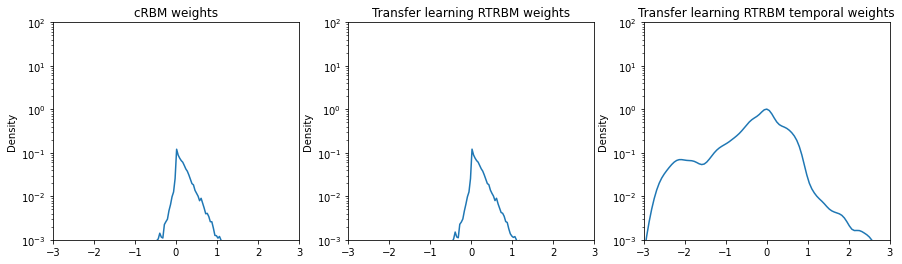

In [12]:


for i, (train, test) in enumerate(zip(train_list, test_list)):
    if os.path.isfile(path2dir + 'tranfer_whole_brain_rtrbm_T_'+str(T[i])+dataset):
        rtrbm = torch.load(path2dir + 'tranfer_whole_brain_rtrbm_T_'+str(T[i])+dataset)
        fig, ax = plt.subplots(1, 3, figsize=(15, 4))

        sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=ax[0])
        ax[0].set_ylim([1e-3, 1e2])
        ax[0].set_xlim([-3, 3])
        ax[0].set_title('cRBM weights')

        sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10],ax=ax[1])
        ax[1].set_ylim([1e-3, 1e2])
        ax[1].set_xlim([-3, 3])
        ax[1].set_title('Transfer learning RTRBM weights')


        sns.kdeplot(rtrbm.U.cpu().ravel(), log_scale=[0, 10],ax=ax[2])
        ax[2].set_ylim([1e-3, 1e2])
        ax[2].set_xlim([-3, 3])
        ax[2].set_title('Transfer learning RTRBM temporal weights')

        plt.show()